In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive/
%cd CWGAN-gp

Mounted at /gdrive
/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/CWGAN-gp


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
plt.rcParams['figure.figsize'] = (20.0, 8.0)

In [ ]:
transmissible_power_all = np.load('transmissible_power_all.npy')
loads_all = np.load('loads_all.npy')
day_label_all = np.load('day_label_all.npy')

In [ ]:
transmissible_power_all = np.expand_dims(transmissible_power_all, axis = -1)

In [ ]:
trans_power_max = transmissible_power_all.max()
trans_power_min = transmissible_power_all.min()

In [ ]:
trans_power_min

242.05266711199695

In [ ]:
#!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
IMG_SHAPE = (24, 1)
BATCH_SIZE = 512

num_channels = 1
num_classes = 4
image_size = 24

# Size of the noise vector
noise_dim = 128

# fashion_mnist = keras.datasets.fashion_mnist
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
mnist = transmissible_power_all
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = transmissible_power_all.reshape(transmissible_power_all.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - trans_power_min) / (trans_power_max - trans_power_min)

all_digits = train_images
all_labels = day_label_all

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
#all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 24, 1))
all_labels = keras.utils.to_categorical(all_labels, 4)

train_images = all_digits
train_labels = all_labels

# Create tf.data.Dataset.
#dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
#dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

#train_images = dataset

# arr = []
# for elem in train_images:
#   arr.append(elem)

# arr = np.asarray(arr).astype(np.float32)

# train_images = arr

generator_in_channels = noise_dim + num_classes
discriminator_in_channels = num_channels + num_classes

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [ ]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3,),
    strides=(1,),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv1D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=(24, discriminator_in_channels))
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding1D((2,2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5,),
        strides=(2,),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5,),
        strides=(2,),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5,),
        strides=(2,),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5,),
        strides=(2,),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24, 5)]           0         
                                                                 
 zero_padding1d_1 (ZeroPaddi  (None, 28, 5)            0         
 ng1D)                                                           
                                                                 
 conv1d_7 (Conv1D)           (None, 14, 64)            1664      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 64)            0         
                                                                 
 conv1d_8 (Conv1D)           (None, 7, 128)            41088     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 128)            0         
                                                     

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3,),
    strides=(1,),
    up_size=2,
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling1D(up_size)(x)
    x = layers.Conv1D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim + num_classes,))
    x = layers.Dense(3 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((3, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1,),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1,),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1,), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping1D(0)(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 132)]             0         
                                                                 
 dense_3 (Dense)             (None, 768)               101376    
                                                                 
 batch_normalization_4 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 768)               0         
                                                                 
 reshape_1 (Reshape)         (None, 3, 256)            0         
                                                                 
 up_sampling1d_3 (UpSampling  (None, 6, 256)           0         
 1D)                                                     

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        # if isinstance(real_images, tuple):
        #     real_images = real_images[0]

        #print(real_images)
        real_images, one_hot_labels = real_images

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            # random_latent_vectors = tf.random.normal(
            #     shape=(batch_size, self.latent_dim)
            # )

            #########################################################################
            # Add dummy dimensions to the labels so that they can be concatenated with
            # the images. This is for the discriminator.
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = tf.repeat(
                image_one_hot_labels, repeats=[image_size * 1]
            )
            image_one_hot_labels = tf.reshape(
                image_one_hot_labels, (-1, image_size, num_classes)
            )

            # Sample random points in the latent space and concatenate the labels.
            # This is for the generator.
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vector_labels = tf.concat(
                [random_latent_vectors, one_hot_labels], axis=1
            )

            # Decode the noise (guided by labels) to fake images.
            generated_images = self.generator(random_vector_labels)

            # Combine them with real images. Note that we are concatenating the labels
            # with these images here.
            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
            # combined_images = tf.concat(
            #     [fake_image_and_labels, real_image_and_labels], axis=0
            # )

            # Assemble labels discriminating real from fake images.
            # labels = tf.concat(
            #     [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            # )
            #########################################################################

            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                #fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_image_and_labels, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_image_and_labels, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_image_and_labels, fake_image_and_labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight
                #d_loss = d_cost

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        ###########################################################################################
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        #print('random_latent_vectors.shape', random_latent_vectors.shape)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))
        ###########################################################################################

        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            #generated_images = self.generator(random_latent_vectors, training=True)
            generated_images = self.generator(random_vector_labels, training=True)

            generated_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_image_and_labels, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(misleading_labels, gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
      
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # one_hot_labels = tf.reshape(tf.convert_to_tensor([self.num_img * [[1.0, 0.0, 0.0, 0.0]]]), (self.num_img, num_classes))
        # random_vector_labels = tf.concat(
        #     [random_latent_vectors, one_hot_labels], axis=1
        # )
        # generated_images = self.model.generator(random_vector_labels)
        # generated_images = generated_images * trans_power_max

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     plt.figure()
        #     plt.plot(img)
        #     plt.savefig("dtlr_gan_training/generated_plot_{i}_{epoch}.png".format(i=i, epoch=epoch))

        if epoch != 0 and epoch % 10 == 0:
          self.model.generator.save("dtlr_gan_training/models/generator_model_{epoch}.h5".format(epoch=epoch))

          random_latent_vectors = tf.random.normal(shape=(7000, 128))

          random_vector_labels = tf.concat(
              [random_latent_vectors, tf.constant(keras.utils.to_categorical(np.random.randint(0, 4, 7000), 4))], axis=1
          )

          # Decode the noise (guided by labels) to fake images.
          generated_images = (wgan.generator(random_vector_labels) + trans_power_min) * (trans_power_max - trans_power_min)

          transmissible_power_all_hours = transmissible_power_all.reshape((transmissible_power_all.shape[0] * transmissible_power_all.shape[1]))
          generated_images_all_hours = generated_images.numpy().reshape((generated_images.numpy().shape[0] * generated_images.numpy().shape[1]))

          fig = plt.figure()
          plt.hist(generated_images_all_hours, bins = np.arange(-1000,1000,2), density = True, label = 'generated');
          plt.hist(transmissible_power_all_hours, bins = np.arange(-1000,1000,2), density = True, label = 'real');
          plt.xlabel('Dynamic Rating [MW]')
          plt.title('Dynamic Rating Histograms')
          plt.legend()
          plt.savefig("dtlr_gan_training/generated_plot__{epoch}.png".format(epoch=epoch))
          plt.close(fig)

Epoch 1/300
15/15 [==============================] - 9s 157ms/step - d_loss: 0.5232 - g_loss: -0.6893
Epoch 2/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.4922 - g_loss: -1.2277
Epoch 3/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.4428 - g_loss: -2.1405
Epoch 4/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.4612 - g_loss: -2.1104
Epoch 5/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.6175 - g_loss: -2.1233
Epoch 6/300
15/15 [==============================] - 2s 157ms/step - d_loss: -0.5755 - g_loss: -1.7075
Epoch 7/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.4722 - g_loss: -2.1641
Epoch 8/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.2762 - g_loss: -2.2586
Epoch 9/300
15/15 [==============================] - 2s 157ms/step - d_loss: -0.3049 - g_loss: -2.0637
Epoch 10/300
15/15 [==============================] - 2s 158ms/step - d_lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


15/15 [==============================] - 4s 289ms/step - d_loss: -0.2272 - g_loss: -17.5664
Epoch 212/300
15/15 [==============================] - 2s 157ms/step - d_loss: -1.0926 - g_loss: -15.1713
Epoch 213/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.2663 - g_loss: -22.7842
Epoch 214/300
15/15 [==============================] - 2s 157ms/step - d_loss: -0.8380 - g_loss: -26.4401
Epoch 215/300
15/15 [==============================] - 2s 156ms/step - d_loss: 0.1110 - g_loss: -28.0451
Epoch 216/300
15/15 [==============================] - 2s 156ms/step - d_loss: 0.1159 - g_loss: -12.2858
Epoch 217/300
15/15 [==============================] - 2s 157ms/step - d_loss: 0.1085 - g_loss: -10.2337
Epoch 218/300
15/15 [==============================] - 2s 156ms/step - d_loss: -0.0528 - g_loss: -13.3554
Epoch 219/300
15/15 [==============================] - 2s 156ms/step - d_loss: 0.5042 - g_loss: -15.0042
Epoch 220/300
15/15 [==============================] - 2s 156ms/

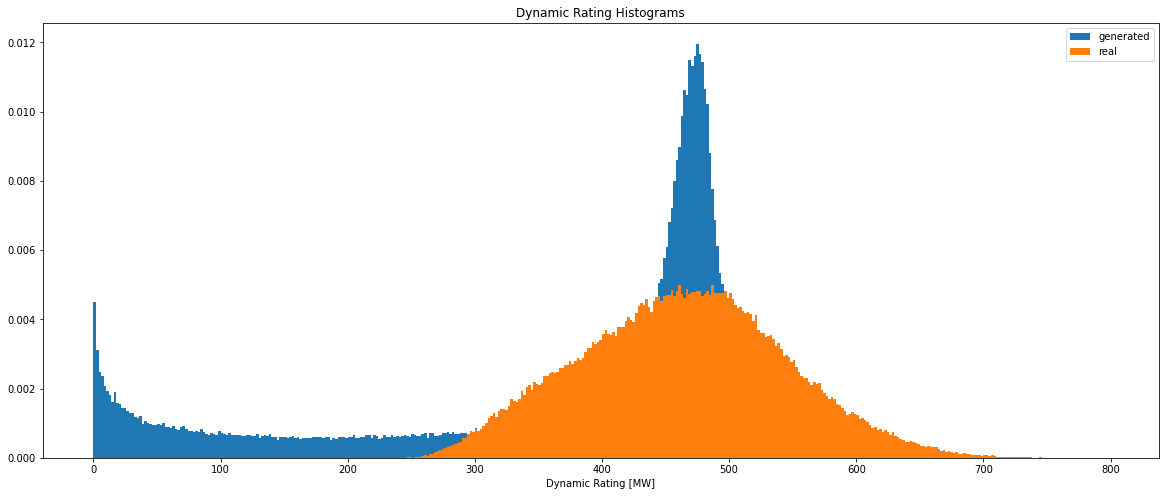

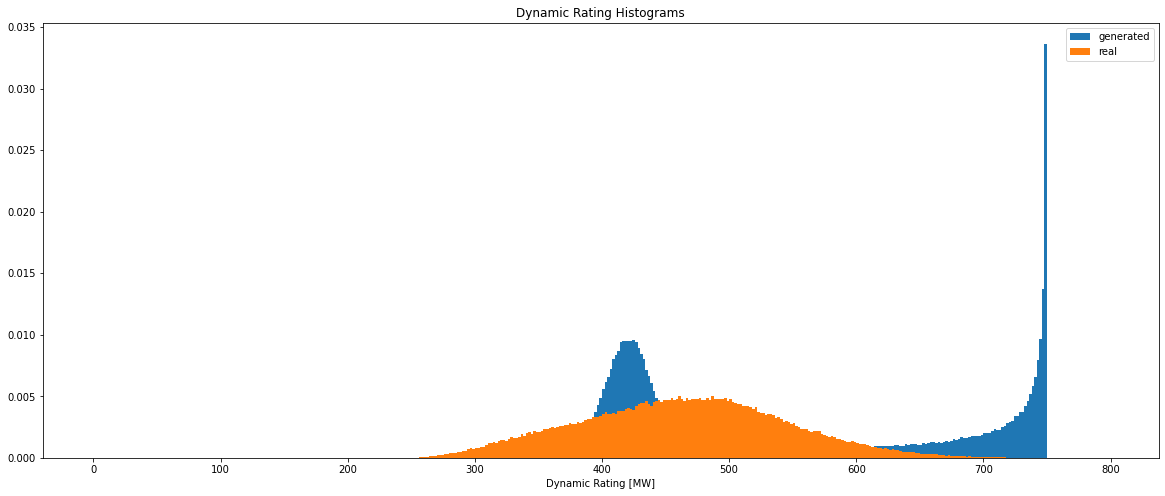

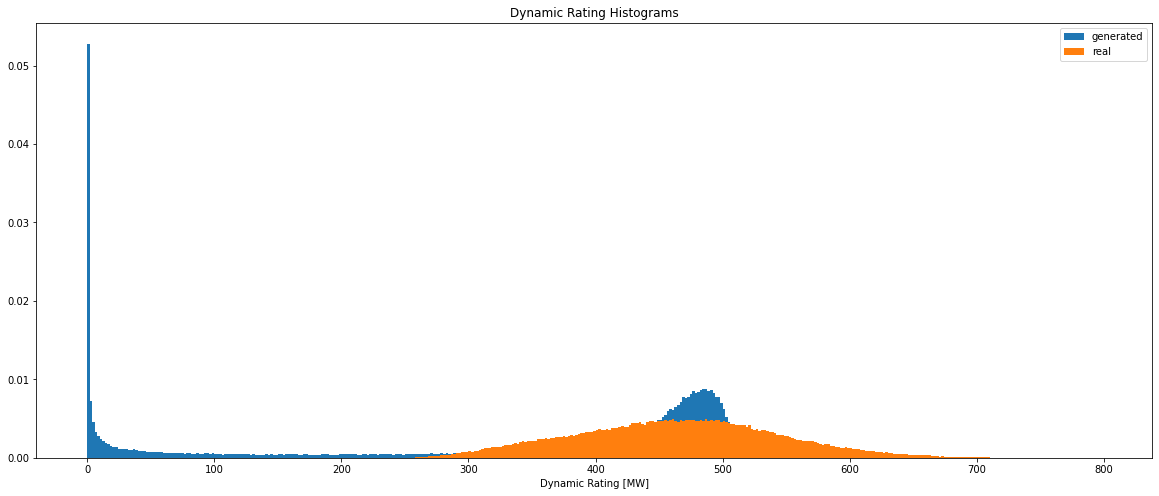

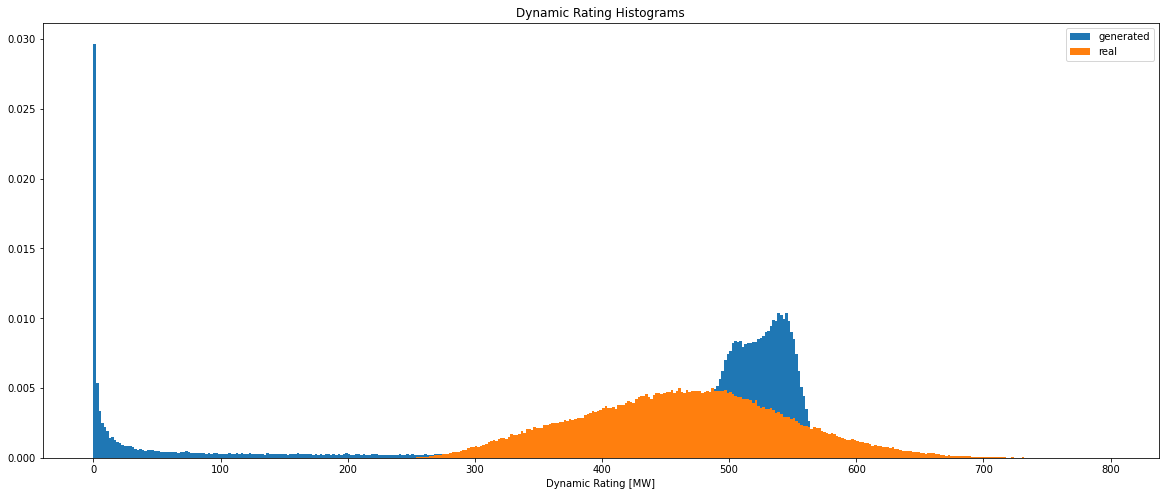

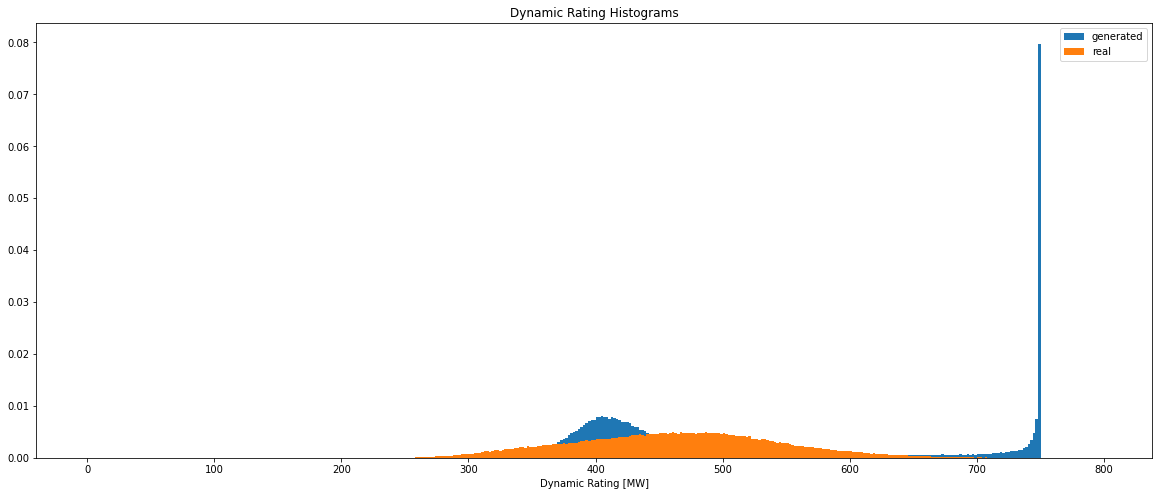

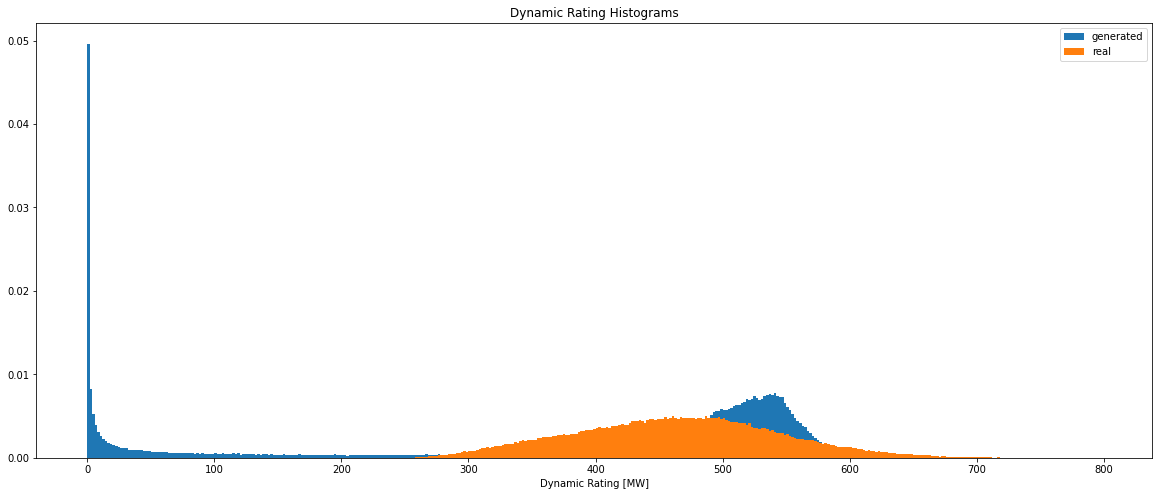

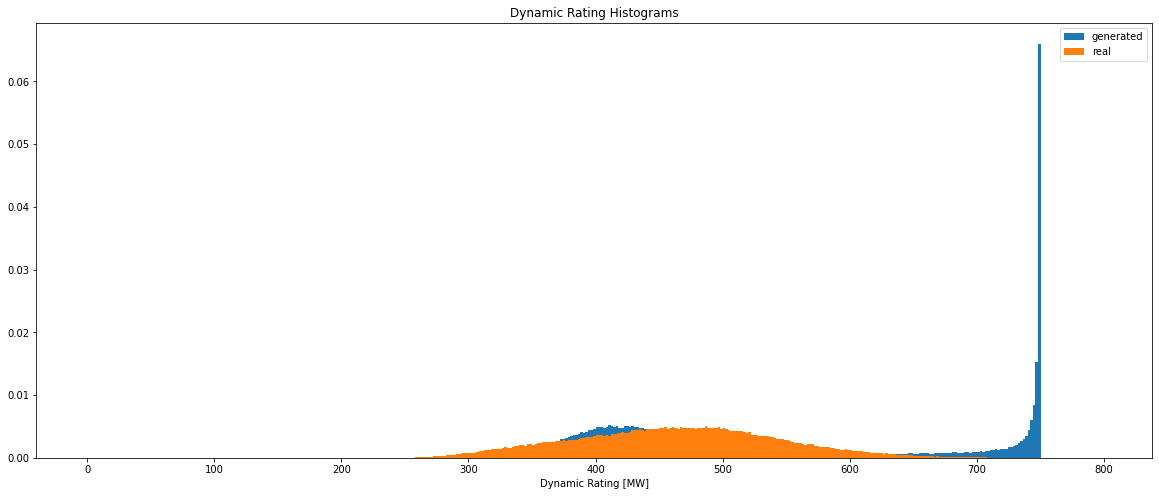

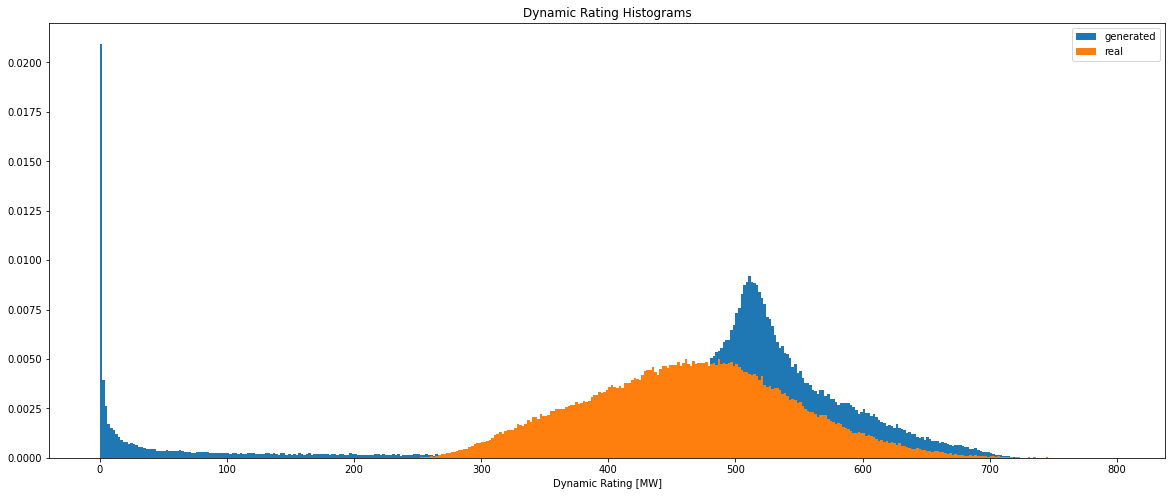

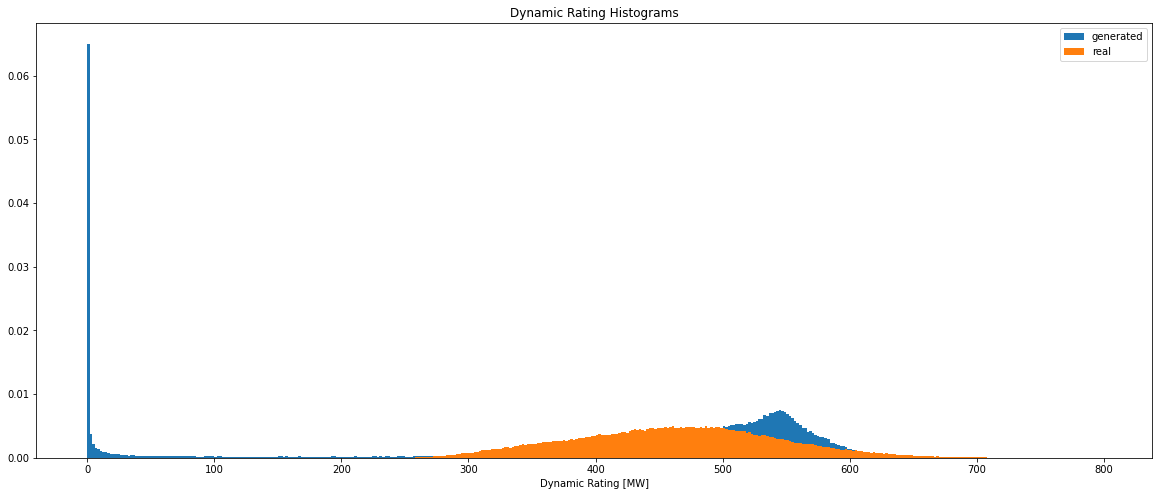

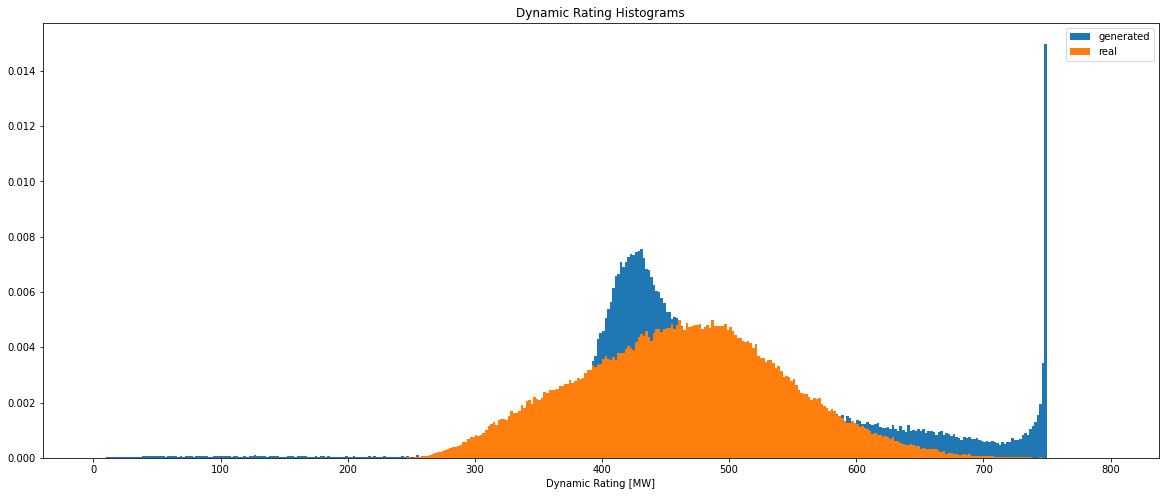

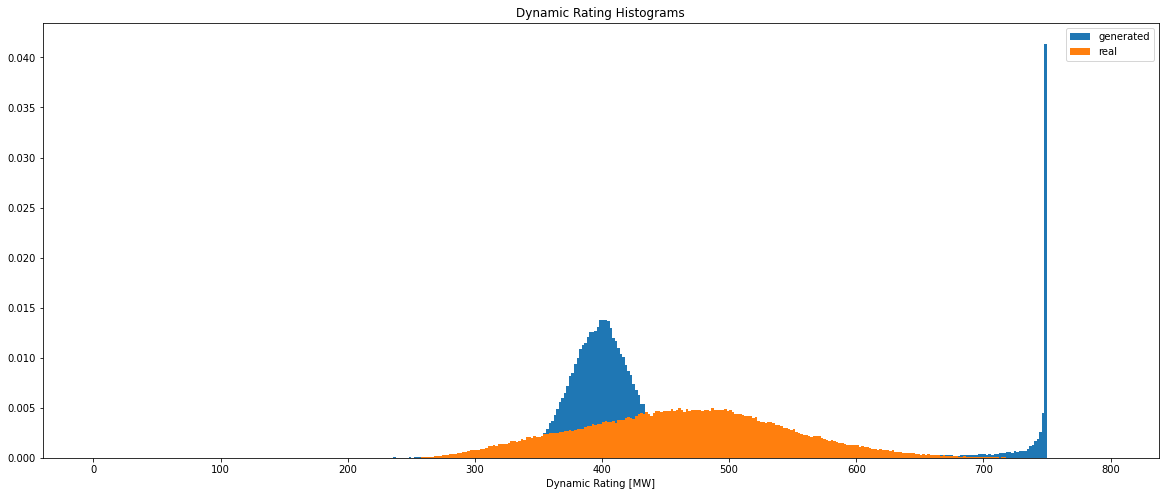

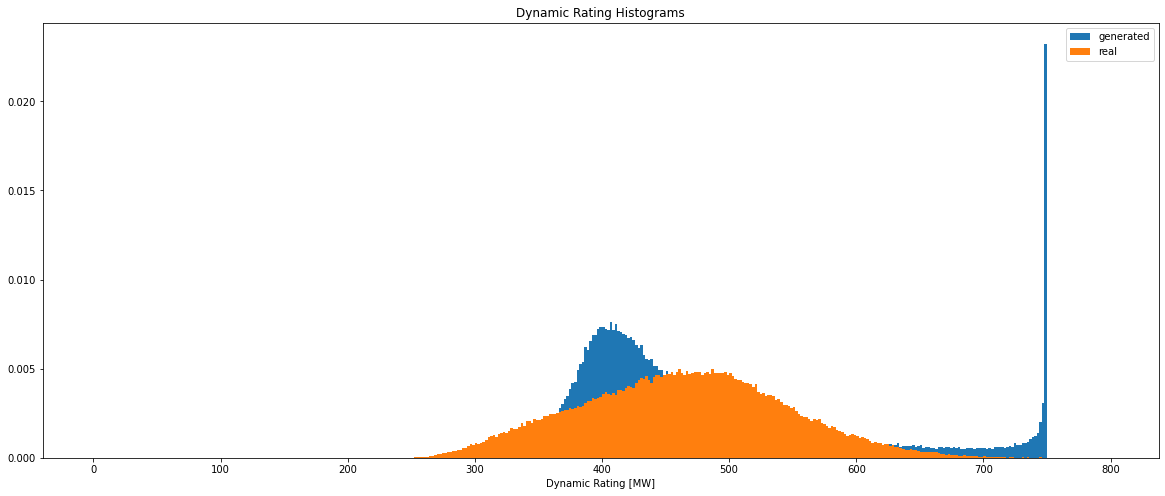

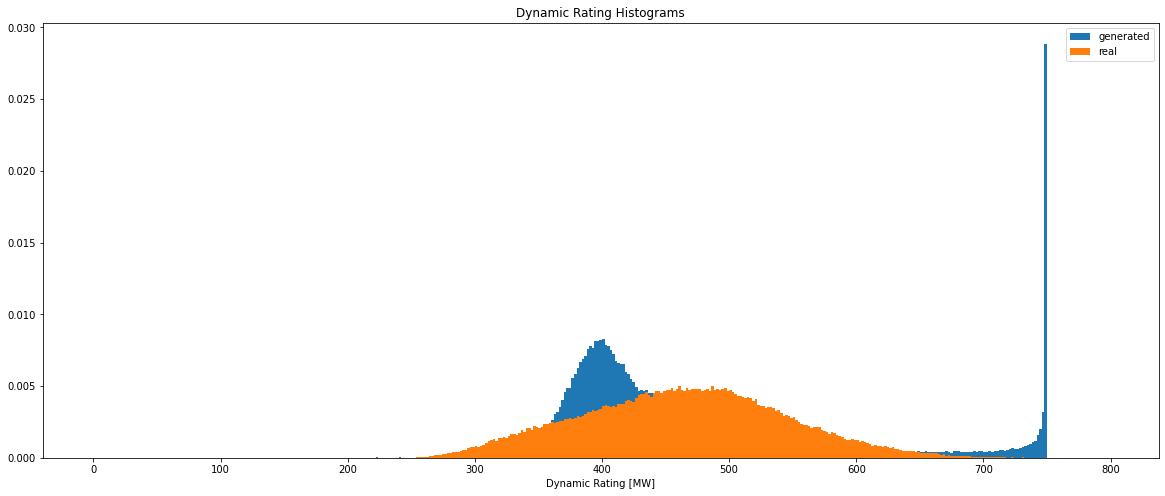

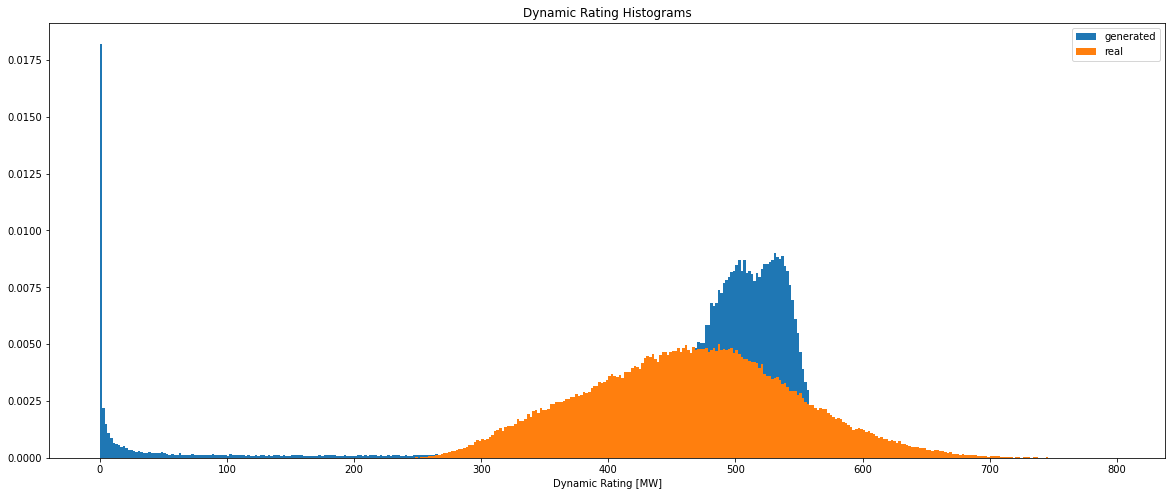

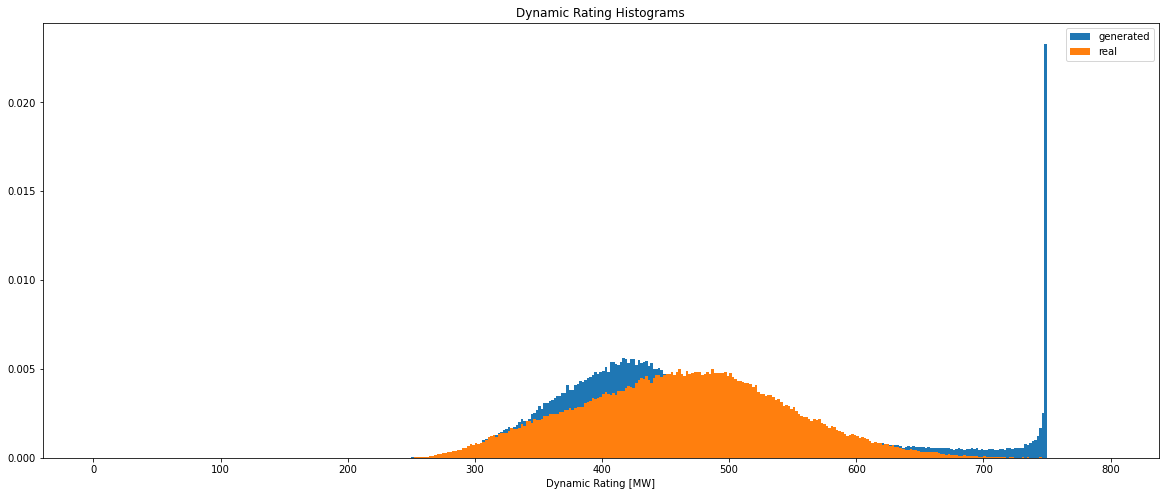

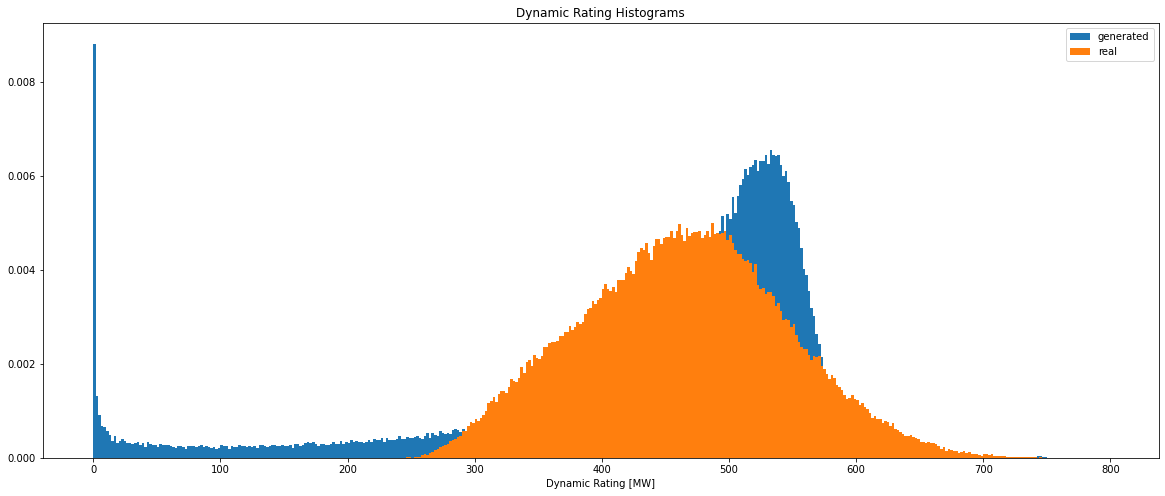

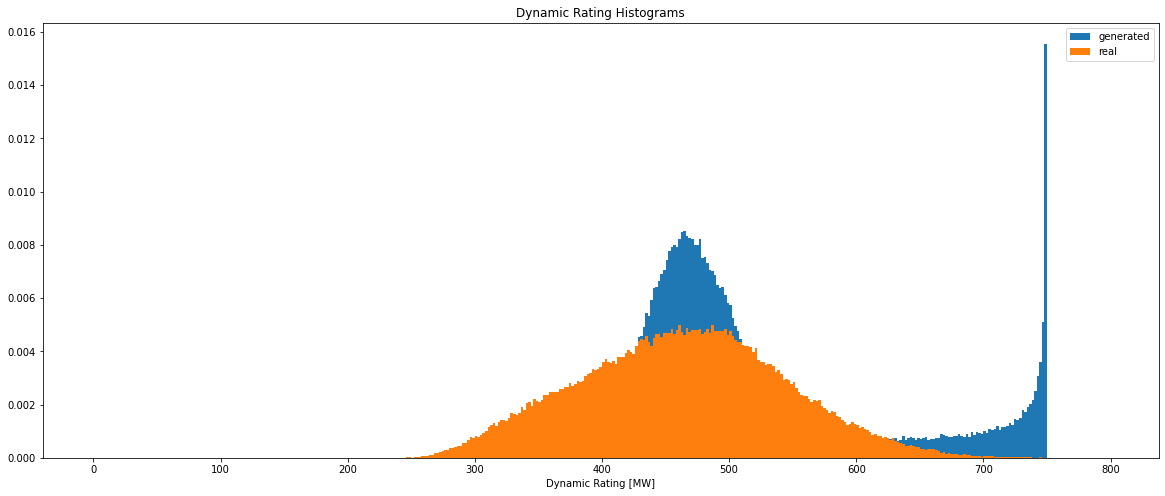

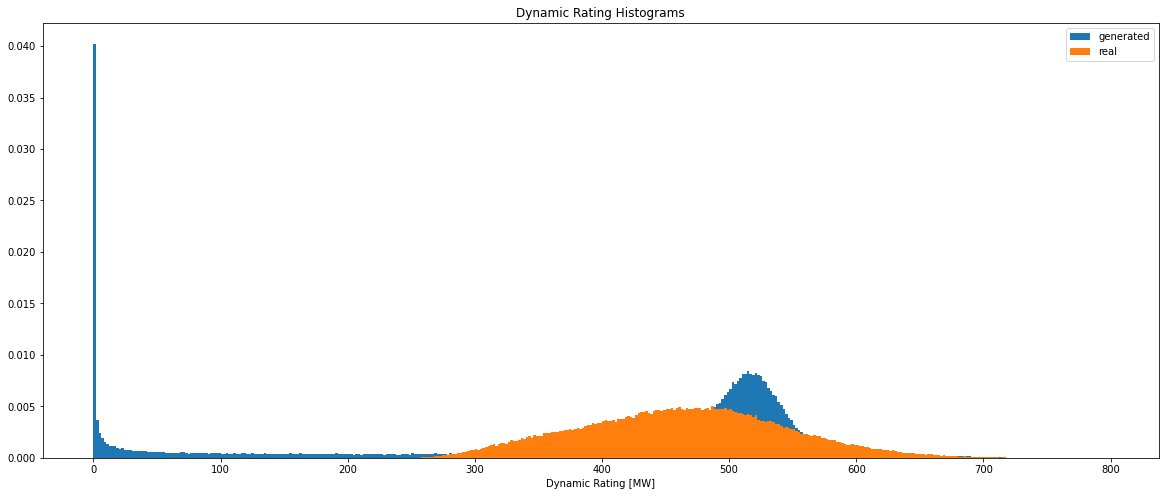

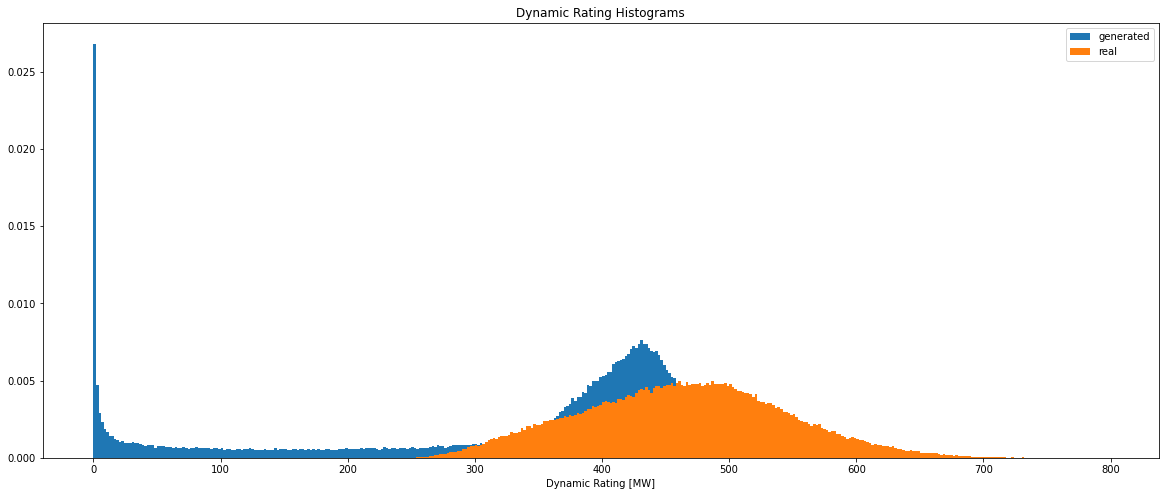

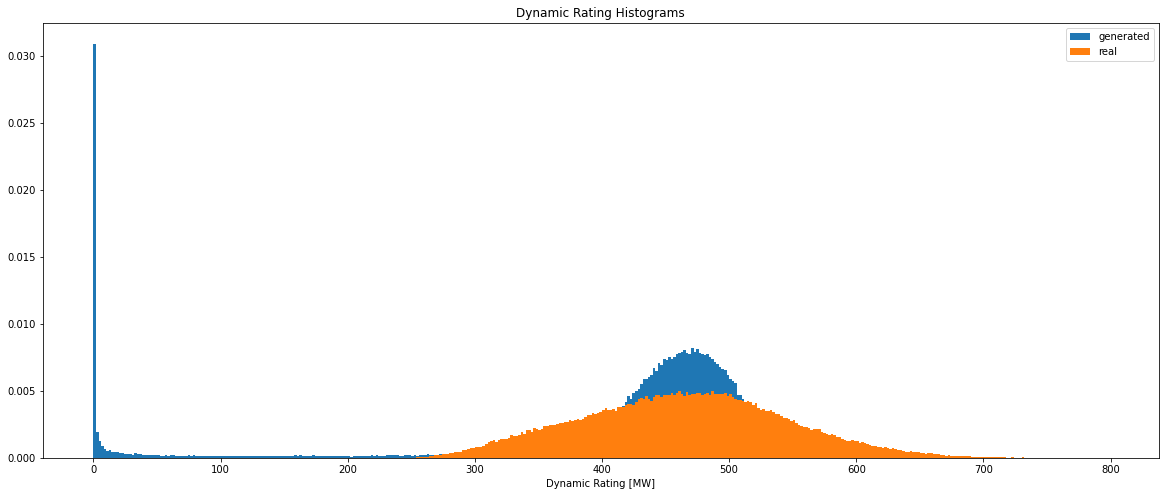

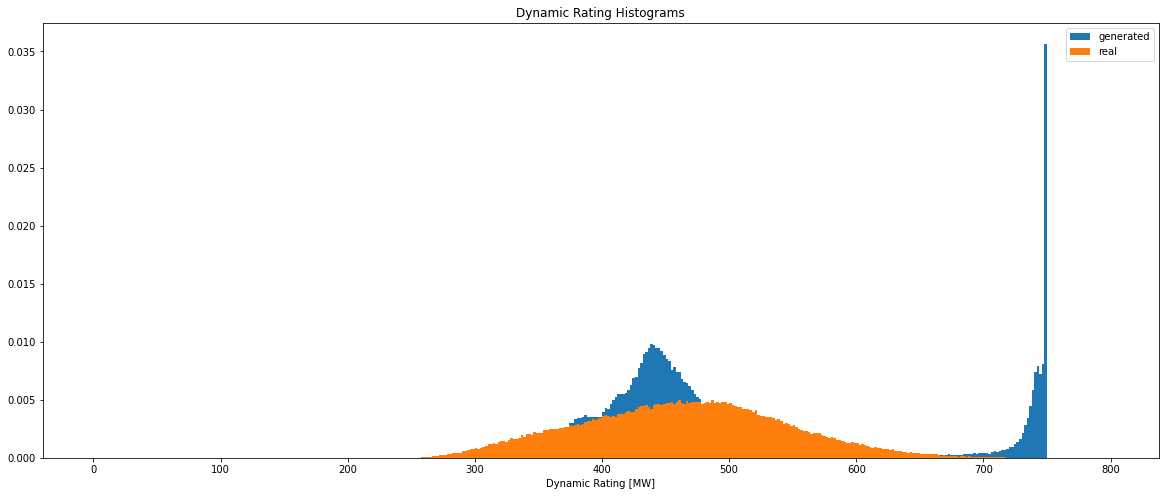

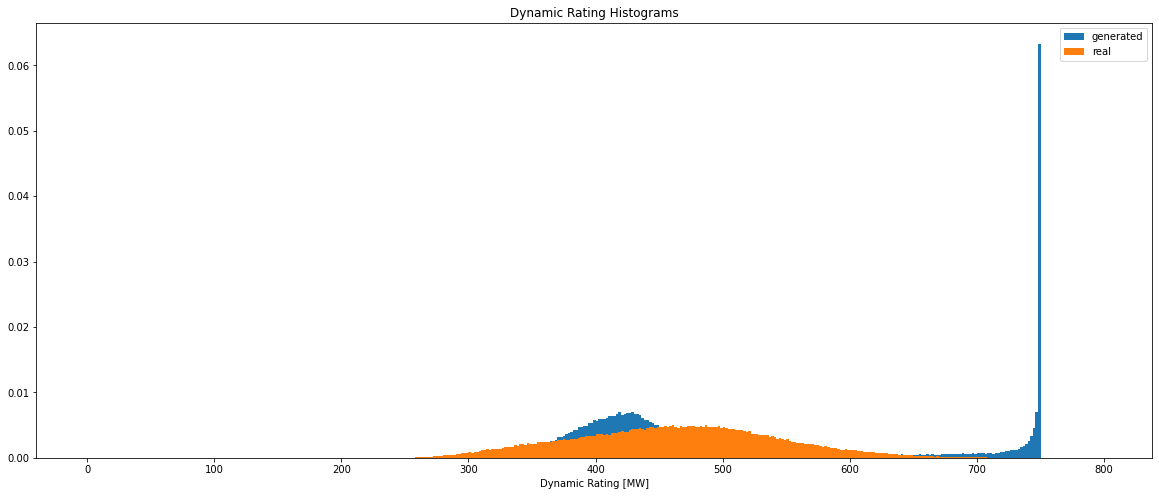

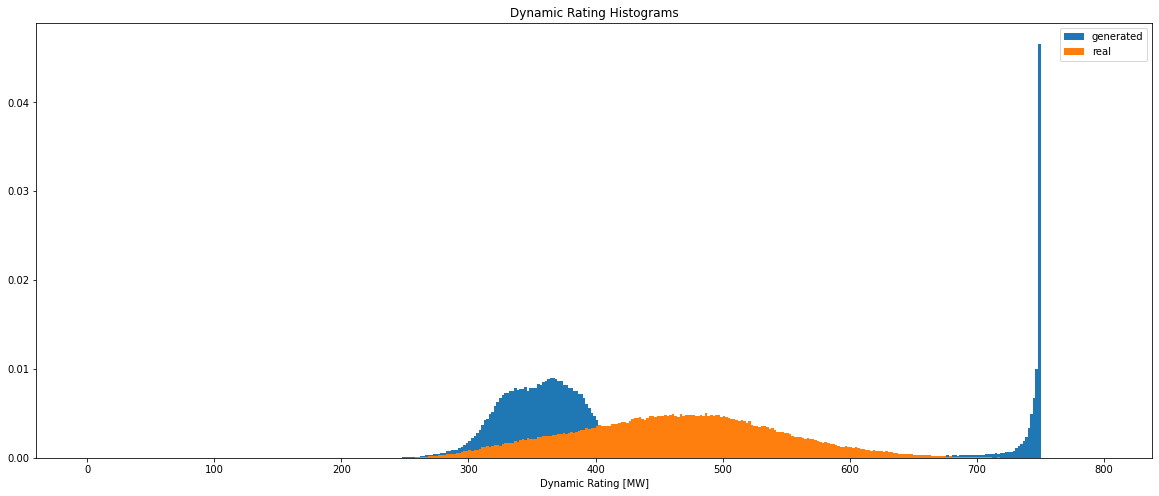

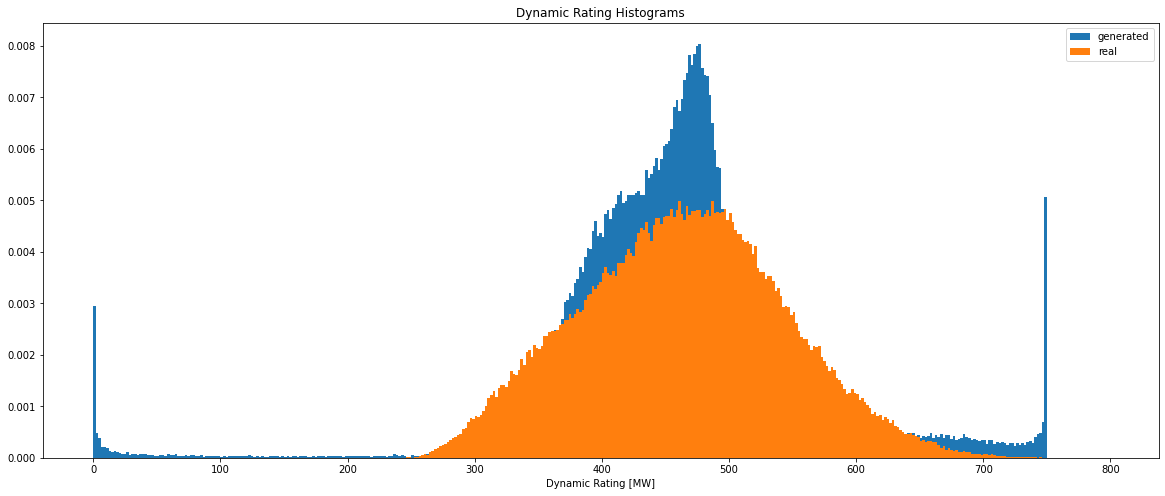

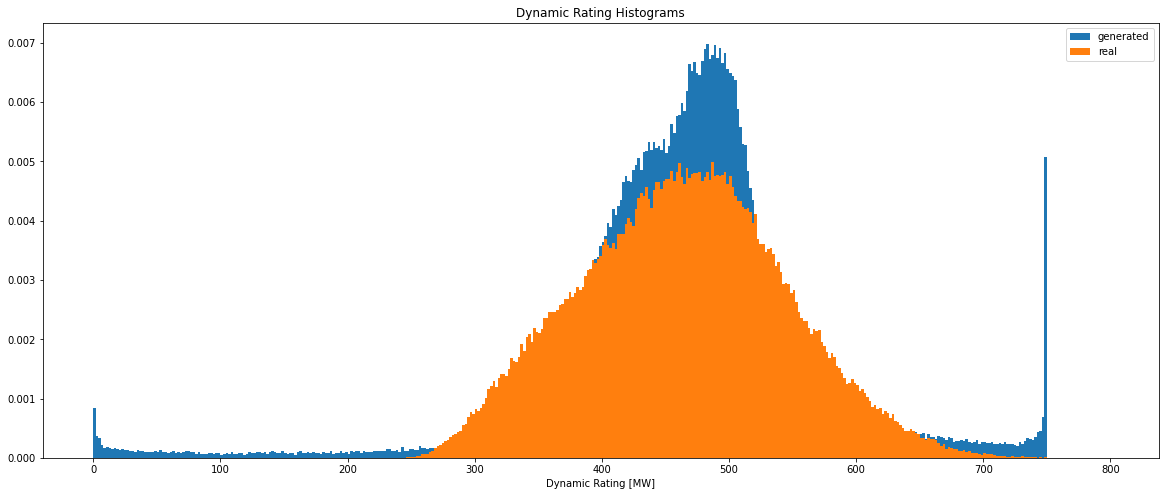

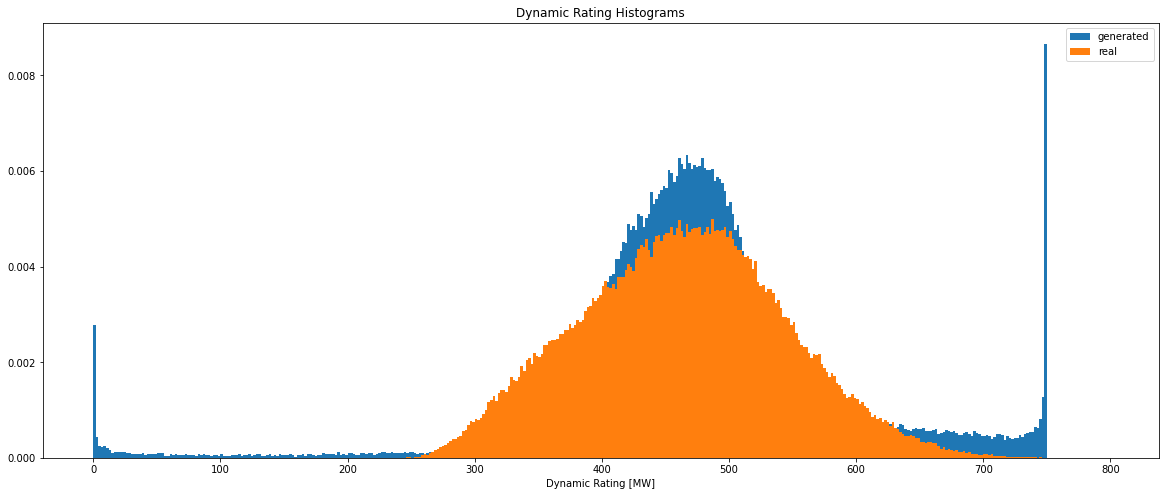

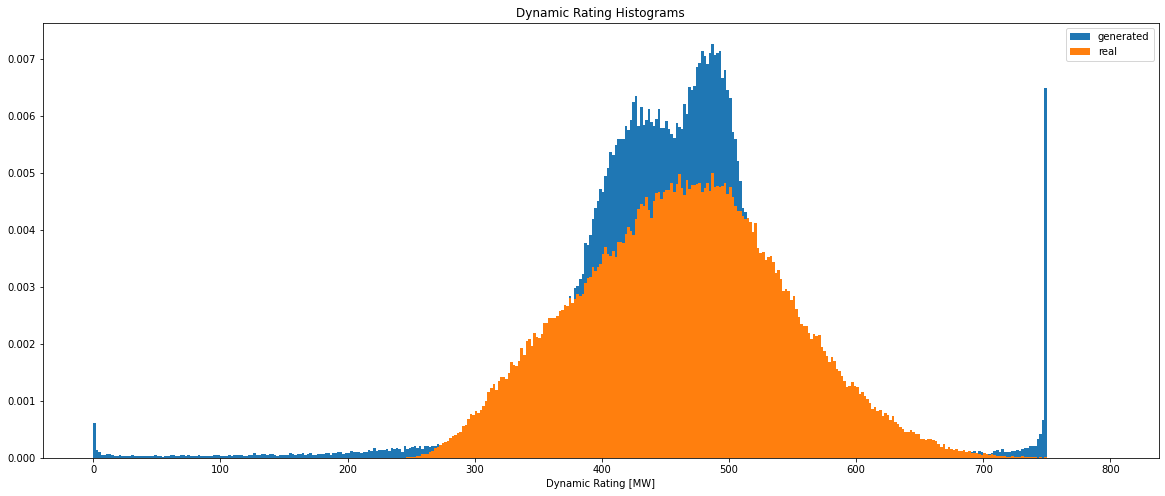

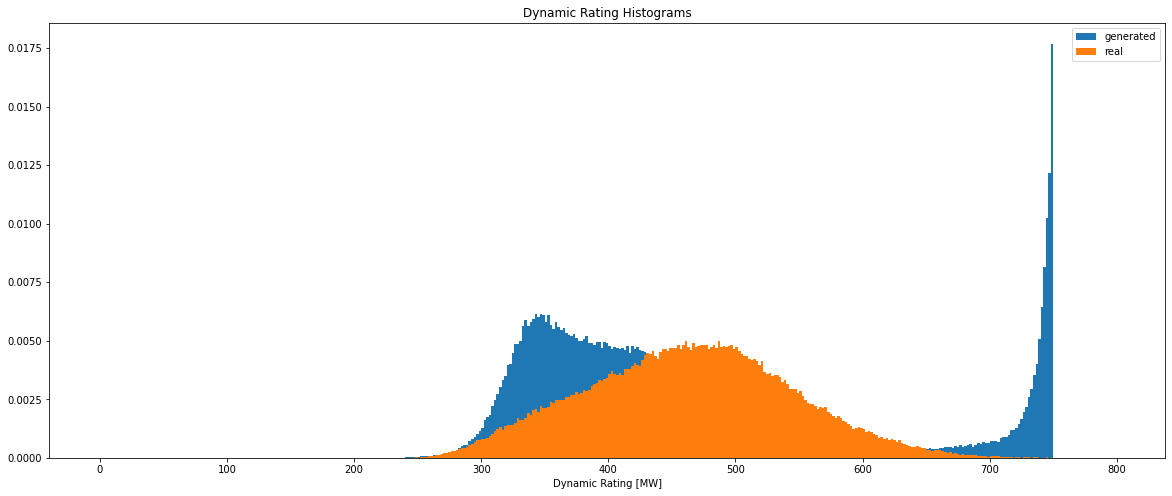

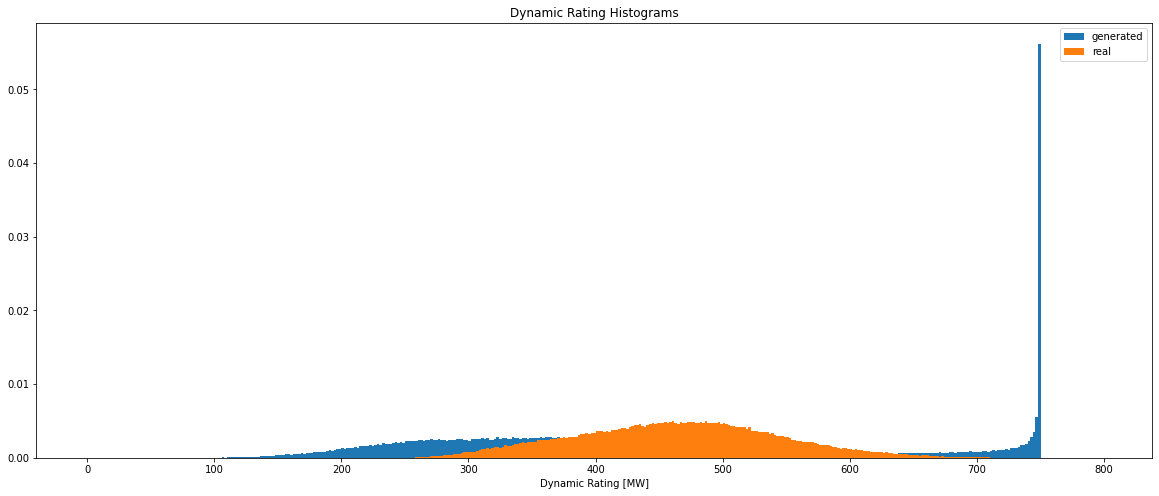

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)

# generator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9
# )
# discriminator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.0002, beta_1=0.5, beta_2=0.9
# )

generator_optimizer = keras.optimizers.RMSprop()

discriminator_optimizer = keras.optimizers.RMSprop()

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
# def generator_loss(fake_img):
#     #return -tf.reduce_mean(fake_img)
#     return -keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(misleading_labels, predictions):
    #return -tf.reduce_mean(fake_img)
    return -keras.losses.BinaryCrossentropy(from_logits=True)(misleading_labels, predictions)


# Set the number of epochs for trainining.
epochs = 300

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
#wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

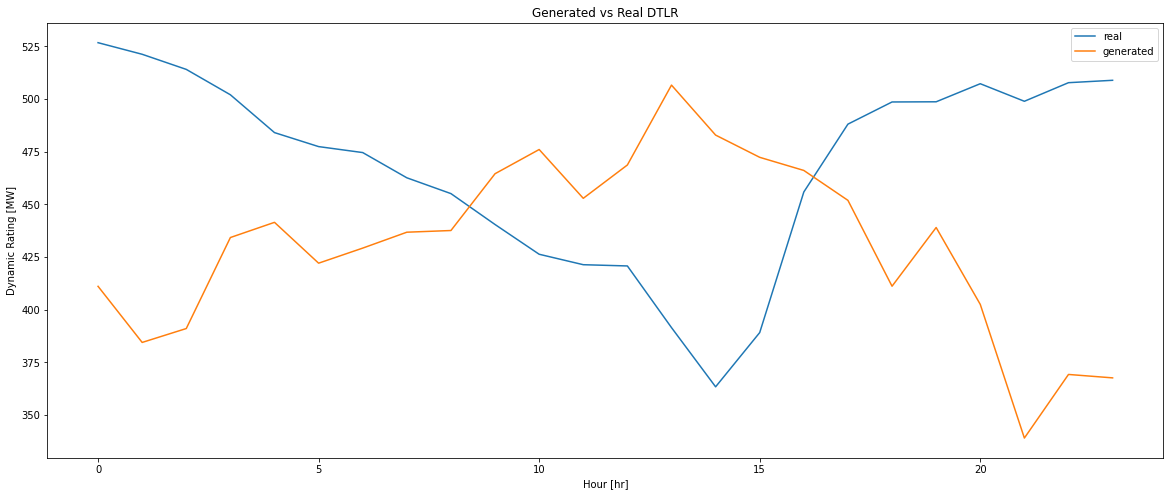

In [ ]:
from IPython.display import display
from PIL import Image

num_example_images = 1

num_latent_dim = 128

random_latent_vectors = tf.random.normal(shape=(num_example_images, num_latent_dim))
one_hot_labels = tf.reshape(tf.convert_to_tensor([num_example_images * [[0.0, 0.0, 0.0, 1.0]]]), (num_example_images, num_classes))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

gen_model = keras.models.load_model('dtlr_gan_training/models/generator_model_250.h5')

generated_images = gen_model(random_vector_labels)
generated_images = (generated_images + trans_power_min) * (trans_power_max - trans_power_min)

img = generated_images[0].numpy()
ind = np.random.randint(1,50,1)
real_image = transmissible_power_all[-ind].reshape((24,))

plt.plot(real_image, label = 'real')
plt.plot(img, label = 'generated')
plt.xlabel('Hour [hr]')
plt.ylabel('Dynamic Rating [MW]')
plt.title('Generated vs Real DTLR')
plt.legend()